In [1]:
import numpy as np
from numpy.linalg import det, lstsq, norm
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
import cv2
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from matplotlib import pyplot as plt
from functools import cmp_to_key
import logging
import time,os
import threading
from queue import Queue
from multiprocessing.dummy import Pool as ThreadPool 
####################
# Global variables #
####################

logger = logging.getLogger(__name__)
float_tolerance = 1e-7

#################
# Main function #
#################

def computeKeypointsAndDescriptors(image,keypointQ,descriptorsQ, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    """Compute SIFT keypoints and descriptors for an input image
    """
    t4 = time.time()
    image = image.astype('float32')
    t5 = time.time()
    base_image = generateBaseImage(image, sigma, assumed_blur)
    t6 = time.time()
    num_octaves = computeNumberOfOctaves(base_image.shape)
    t7 = time.time()
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    t8 = time.time()
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    t9 = time.time()
    dog_images = generateDoGImages(gaussian_images)
    t10 = time.time()
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    t11 = time.time()
    keypoints = removeDuplicateKeypoints(keypoints)
    t12 = time.time()
    keypoints = convertKeypointsToInputImageSize(keypoints)
    t13 = time.time()
    descriptors = generateDescriptors(keypoints, gaussian_images)
    t14 = time.time()

    print('image.astype: ' + str(t5-t4) + ' seconds')
    print('generateBaseImage: ' + str(t6-t5) + ' seconds')
    print('computeNumberOfOctaves: ' + str(t7-t6) + ' seconds')
    print('generateGaussianKernels: ' + str(t8-t7) + ' seconds')
    print('generateGaussianImages: ' + str(t9-t8) + ' seconds')
    print('generateDoGImages: ' + str(t10-t9) + ' seconds')
    print('findScaleSpaceExtrema: ' + str(t11-t10) + ' seconds')
    print('removeDuplicateKeypoints: ' + str(t12-t11) + ' seconds')
    print('convertKeypointsToInputImageSize: ' + str(t13-t12) + ' seconds')
    print('generateDescriptors: ' + str(t14-t13) + ' seconds')
    
    keypointQ.put(keypoints)
    descriptorsQ.put(descriptors)

#########################
# Image pyramid related #
#########################

def generateBaseImage(image, sigma, assumed_blur):
    """Generate base image from input image by upsampling by 2 in both directions and blurring
    """
    logger.debug('Generating base image...')
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  # the image blur is now sigma instead of assumed_blur

def computeNumberOfOctaves(image_shape):
    """Compute number of octaves in image pyramid as function of base image shape (Opencv2 default)
    """
    return int(round(log(min(image_shape)) / log(2)/2 ))

def generateGaussianKernels(sigma, num_intervals):
    """Generate list of gaussian kernels at which to blur the input image. Default values of sigma, intervals, and octaves follow section 3 of Lowe's paper.
    """
    logger.debug('Generating scales...')
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images
    """
    logger.debug('Generating Gaussian images...')
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return array(gaussian_images)

def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    logger.debug('Generating Difference-of-Gaussian images...')
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return array(dog_images)

###############################
# Scale-space extrema related #
###############################
def P_compute(image_index,first_image, second_image, third_image, octave_index, num_intervals,
              dog_images_in_octave, sigma, contrast_threshold, image_border_width,gaussian_images,
              results):
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)
    keypoint=[]
    for i in range(image_border_width, first_image.shape[0] - image_border_width):
        for j in range(image_border_width, first_image.shape[1] - image_border_width):
            if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                if localization_result is not None:
                    keypoint, localized_image_index = localization_result
                    keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                    for keypoint_with_orientation in keypoints_with_orientations:
                        results.put(keypoint_with_orientation)

def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid
    """
    keypoints=[]
    results=Queue()
    logger.debug('Finding scale-space extrema...')
    threads = list()
    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            t = threading.Thread(target=P_compute,args=(image_index,first_image, second_image, third_image, octave_index, num_intervals,
                                                                    dog_images_in_octave, sigma, contrast_threshold, image_border_width,gaussian_images,results))
            threads.append(t)
            t.start()
    for thread in threads:
        thread.join()
    t = time.time()
    while(results.empty()==False):
        keypoints.append(results.get())
    t1=time.time()
    print("QUEUEOUTTIME",str(t1-t))
    return keypoints

def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

'''
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            if all(center_pixel_value >= first_subimage):
                if all(center_pixel_value >= third_subimage):
                    if all(center_pixel_value >= second_subimage):
                        return True
            return False
        elif center_pixel_value < 0:
            if all(center_pixel_value <= first_subimage):
                if all(center_pixel_value <= third_subimage):
                    if all(center_pixel_value <= second_subimage):
                        return True
            return False
    return False
'''
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
    """
    logger.debug('Localizing scale-space extrema...')
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return Opencv2 KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
    # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
    # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
    # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

#########################
# Keypoint orientations #
#########################

def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    logger.debug('Computing keypoint orientations...')
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

##############################
# Duplicate keypoint removal #
##############################

def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

#############################
# Keypoint scale conversion #
#############################

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

#########################
# Descriptor generation #
#########################

def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    logger.debug('Generating descriptors...')
    descriptors = []

    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows Opencv2 convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (Opencv2 convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')
'''
def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    
    desQ1 = Queue()
    desQ2 = Queue()
    desQ3 = Queue()
    desQ4 = Queue()
    desQ5 = Queue()
    threads = list()
    descriptors=[]
    L = len(keypoints)
    t1= threading.Thread(target=generateDescriptors_sub,args=(desQ1,keypoints[:int(L/5)], gaussian_images))
    t2= threading.Thread(target=generateDescriptors_sub,args=(desQ2,keypoints[int(L/5):int(2*L/5)], gaussian_images))
    t3= threading.Thread(target=generateDescriptors_sub,args=(desQ3,keypoints[int(2*L/5):int(3*L/5)], gaussian_images))
    t4= threading.Thread(target=generateDescriptors_sub,args=(desQ4,keypoints[int(3*L/5):int(4*L/5)], gaussian_images))
    t5= threading.Thread(target=generateDescriptors_sub,args=(desQ5,keypoints[int(4*L/5):], gaussian_images))
    threads.append(t1)
    threads.append(t2)
    threads.append(t3)
    threads.append(t4)
    threads.append(t5)
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    while(desQ1.empty()==False):
        descriptors.append(desQ1.get())
    while(desQ2.empty()==False):
        descriptors.append(desQ2.get())
    while(desQ3.empty()==False):
        descriptors.append(desQ3.get())
    while(desQ4.empty()==False):
        descriptors.append(desQ4.get())
    while(desQ5.empty()==False):
        descriptors.append(desQ5.get())
    return array(descriptors, dtype='float32')
    

def generateDescriptors_sub(desQ,keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows Opencv2 convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (Opencv2 convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        desQ.put(descriptor_vector)
'''
def stitch_image(srcImg,testImg,kp1,kp2,des1,des2):
	FLANN_INDEX_KDTREE = 1
	index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
	search_params = dict(checks=50)
	flann = cv2.FlannBasedMatcher(index_params, search_params)
	matches = flann.knnMatch(des1, des2, k=2)

	# Need to draw only good matches, so create a mask
	matchesMask = [[0, 0] for i in range(len(matches))]

	good = []
	pts1 = []
	pts2 = []
	# ratio test as per Lowe's paper
	for i, (m, n) in enumerate(matches):
	    if m.distance < 0.7*n.distance:
	        good.append(m)
	        pts2.append(kp2[m.trainIdx].pt)
	        pts1.append(kp1[m.queryIdx].pt)
	        matchesMask[i] = [1, 0]

	MIN_MATCH_COUNT = 10
	if len(good) > MIN_MATCH_COUNT:
		src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
		dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
		M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
		warpImg = cv2.warpPerspective(testImg, np.array(M), (testImg.shape[1]+srcImg.shape[1],testImg.shape[0]), flags=cv2.WARP_INVERSE_MAP)
		print("testImg.shape[1]+srcImg.shape[1]: ",testImg.shape[1]+srcImg.shape[1])
		print("warpImg.shape: ",warpImg.shape)
		# plt.figure()
		# plt.imshow(warpImg)
		# plt.show()
		warpImg[0:srcImg.shape[0], 0:srcImg.shape[1]] = srcImg
		res = change_size(warpImg)
		print("res.shape: ",res.shape)
		result = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

		return result;
	else:
	    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
	    matchesMask = None


def change_size(image): #delete black region
    img = cv2.medianBlur(image, 5)
    b = cv2.threshold(img, 15, 255, cv2.THRESH_BINARY)
    binary_image = b[1]
    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)
    x = binary_image.shape[0]
    y = binary_image.shape[1]
    edges_x = []
    edges_y = []
    for i in range(x):
        for j in range(y):
            if binary_image[i][j] == 255:
                edges_x.append(i)
                edges_y.append(j)

    left = min(edges_x)
    right = max(edges_x)
    width = right - left
    bottom = min(edges_y)
    top = max(edges_y)
    height = top - bottom
    pre1_picture = image[:, bottom:bottom + height]
    return pre1_picture

def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)
    return array_of_img

In [6]:

img1 = cv2.imread('parrington/1.jpg')
img2 = cv2.imread('parrington/2.jpg')
top, bot, left, right = 0, 0, 0, img1.shape[1]
srcImg = cv2.copyMakeBorder(img1, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
testImg = cv2.copyMakeBorder(img2, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
image = cv2.cvtColor(srcImg, cv2.COLOR_BGR2GRAY)
sigma = 1.6
assumed_blur=0.5
num_intervals=3
image_border_width=1

In [7]:
base_image = generateBaseImage(image, sigma, assumed_blur)
num_octaves = computeNumberOfOctaves(base_image.shape)
gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
dog_images = generateDoGImages(gaussian_images)

In [8]:
keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width) #11:46

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:250: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:252: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:251: RuntimeWarning: overflow encountered in ubyte_scalars


ValueError: not enough values to unpack (expected 3, got 2)

2246

array([[array([[ 5.567215  ,  6.359909  ,  6.8620377 , ..., -7.400406  ,
        -9.147659  , -9.197311  ],
       [ 5.390114  ,  6.2499695 ,  7.1302643 , ..., -4.899292  ,
        -5.5002136 , -5.145462  ],
       [ 5.035713  ,  6.035469  ,  7.670738  , ...,  0.48747253,
         1.5072937 ,  2.3714752 ],
       ...,
       [-0.13725662, -0.23817444, -0.28359985, ...,  1.2681961 ,
         1.5160027 ,  1.5552788 ],
       [-1.4523125 , -1.4910164 , -1.3298798 , ...,  1.4148407 ,
         1.4624939 ,  1.4441528 ],
       [-2.0672836 , -2.0686188 , -1.8040047 , ...,  1.2038574 ,
         1.147831  ,  1.1025047 ]], dtype=float32),
        array([[ 9.569923  ,  9.435791  ,  8.352318  , ..., -3.32872   ,
        -5.739151  , -6.4465637 ],
       [ 9.584396  ,  9.519722  ,  8.608543  , ..., -1.911438  ,
        -4.0362854 , -4.6394196 ],
       [ 9.630775  ,  9.7293625 ,  9.212784  , ...,  0.98028564,
        -0.67533875, -1.1149902 ],
       ...,
       [-0.15290833, -0.13790512, -0.070922

0

NameError: name 'candidate_pixel' is not defined

image.astype: 0.0009980201721191406 seconds
generateBaseImage: 0.009973526000976562 seconds
computeNumberOfOctaves: 0.0 seconds
generateGaussianKernels: 0.0 seconds
generateGaussianImages: 2.559159994125366 seconds
generateDoGImages: 5.021598815917969 seconds
findScaleSpaceExtrema: 99.68644833564758 seconds
removeDuplicateKeypoints: 0.007978677749633789 seconds
convertKeypointsToInputImageSize: 0.019979238510131836 seconds
generateDescriptors: 189.67909955978394 seconds
image.astype: 0.0 seconds
generateBaseImage: 0.006982564926147461 seconds
computeNumberOfOctaves: 0.0 seconds
generateGaussianKernels: 0.0 seconds
generateGaussianImages: 0.0388951301574707 seconds
generateDoGImages: 0.014961719512939453 seconds
findScaleSpaceExtrema: 100.47336220741272 seconds
removeDuplicateKeypoints: 0.08832955360412598 seconds
convertKeypointsToInputImageSize: 0.003962039947509766 seconds
generateDescriptors: 198.14648699760437 seconds


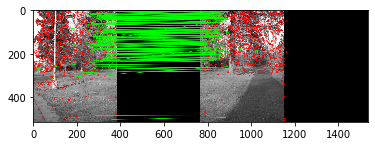

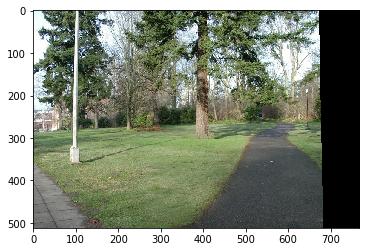

In [4]:
if __name__ == '__main__':
    img1 = cv2.imread('parrington/5.jpg')
    img2 = cv2.imread('parrington/6.jpg')
    top, bot, left, right = 0, 0, 0, img1.shape[1]
    srcImg = cv2.copyMakeBorder(img1, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    testImg = cv2.copyMakeBorder(img2, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    img1gray = cv2.cvtColor(srcImg, cv2.COLOR_BGR2GRAY)
    img2gray = cv2.cvtColor(testImg, cv2.COLOR_BGR2GRAY)
    
    #-----------------------------------------------------------
    # # find the keypoints and descriptors with SIFT
    kp1Q=Queue()
    kp2Q=Queue()
    des1Q=Queue()
    des2Q=Queue()
    main_threads = list()
    main_threads.append(threading.Thread(target=computeKeypointsAndDescriptors,args=(img1gray,kp1Q,des1Q,)))
    main_threads.append(threading.Thread(target=computeKeypointsAndDescriptors,args=(img2gray,kp2Q,des2Q,)))
    for thread in main_threads:
        thread.start()
    for thread in main_threads:
        thread.join()
    kp1 = kp1Q.get()
    kp2 = kp2Q.get()
    des1 = des1Q.get()
    des2 = des2Q.get()
    
    # kp1, des1 = computeKeypointsAndDescriptors(img1gray)
    # kp2, des2 = computeKeypointsAndDescriptors(img2gray)
    
    #-----------------------------------------------------------
    # FLANN parameters
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0, 0] for i in range(len(matches))]

    good = []
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
            matchesMask[i] = [1, 0]

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=0)
    img3 = cv2.drawMatchesKnn(img1gray, kp1, img2gray, kp2, matches, None, **draw_params)
    plt.imshow(img3, )
    plt.savefig("SIFTTT_NCTU_12.png")
    plt.show()

    rows, cols = srcImg.shape[:2]
    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        warpImg = cv2.warpPerspective(testImg, np.array(M), (testImg.shape[1], testImg.shape[0]), flags=cv2.WARP_INVERSE_MAP)

        for col in range(0, cols):
            if srcImg[:, col].any() and warpImg[:, col].any():
                left = col
                break
        for col in range(cols-1, 0, -1):
            if srcImg[:, col].any() and warpImg[:, col].any():
                right = col
                break

        res = np.zeros([rows, cols, 3], np.uint8)
        for row in range(0, rows):
            for col in range(0, cols):
                if not srcImg[row, col].any():
                    res[row, col] = warpImg[row, col]
                elif not warpImg[row, col].any():
                    res[row, col] = srcImg[row, col]
                else:
                    srcImgLen = float(abs(col - left))
                    testImgLen = float(abs(col - right))
                    alpha = srcImgLen / (srcImgLen + testImgLen)
                    res[row, col] = np.clip(srcImg[row, col] * (1-alpha) + warpImg[row, col] * alpha, 0, 255)

        # opencv2 is bgr, matplotlib is rgb
        res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
        # show the result
        plt.figure()
        plt.imshow(res)
        plt.savefig("Panooo_NCTU_12.png")
        plt.show()
    else:
        print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
        matchesMask = None



In [39]:
if __name__ == '__main__':
	top, bot, left, right = 0, 0, 0, 0
	array_of_img =[]
	directory_name = 'parrington'
	array_of_img = read_directory(directory_name)
	sift = cv2.SIFT_create()

	# Method 1
	#------------------------------------------------------------------------------------
	# kp = []
	# des = []
	# for i in range(len(array_of_img)):
	# 	print(i,"/",len(array_of_img))
	# 	array_of_img[i] = cv2.copyMakeBorder(array_of_img[i], top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
	# 	gray_img = cv2.cvtColor(array_of_img[i], cv2.COLOR_BGR2GRAY)
	# 	kpp, dess = sift.detectAndCompute(gray_img, None)
	# 	print(kpp)
	# 	kp.append(kpp)
	# 	des.append(dess)

	# res = stitch_image(array_of_img[0],array_of_img[1],kp[0],kp[1],des[0],des[1],2)
	# plt.figure()
	# plt.imshow(res)
	# plt.show()

	# for i in range(2,len(array_of_img)):
	# 	print("i= ",i)
	# 	res = cv2.copyMakeBorder(res, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
	# 	res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
	# 	res = stitch_image(res,array_of_img[i],kp[0:i-1],kp[i],des[0:i-1],des[i],2)
	# 	plt.figure()
	# 	plt.imshow(res)
	# 	plt.show()
	#------------------------------------------------------------------------------------

	# Method 2
	#------------------------------------------------------------------------------------

	gray_img = []
	array_of_img[0] = cv2.copyMakeBorder(array_of_img[0], top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
	array_of_img[1] = cv2.copyMakeBorder(array_of_img[1], top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
	img1gray = cv2.cvtColor(array_of_img[0], cv2.COLOR_BGR2GRAY)
	img2gray = cv2.cvtColor(array_of_img[1], cv2.COLOR_BGR2GRAY)
	kp1Q=Queue()
	kp2Q=Queue()
	des1Q=Queue()
	des2Q=Queue()
	main_threads = list()
	main_threads.append(threading.Thread(target=computeKeypointsAndDescriptors,args=(img1gray,kp1Q,des1Q,)))
	main_threads.append(threading.Thread(target=computeKeypointsAndDescriptors,args=(img2gray,kp2Q,des2Q,)))
	for thread in main_threads:
	    thread.start()
	for thread in main_threads:
	    thread.join()
	kp1 = kp1Q.get()
	kp2 = kp2Q.get()
	des1 = des1Q.get()
	des2 = des2Q.get()
	res = stitch_image(array_of_img[0],array_of_img[1],kp1,kp2,des1,des2)
	plt.figure()
	plt.imshow(res)
	plt.show()

	for i in range(2,len(array_of_img)):
		print(i,"/",len(array_of_img))
		array_of_img[i] = cv2.copyMakeBorder(array_of_img[i], top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
		img2gray = cv2.cvtColor(array_of_img[i], cv2.COLOR_BGR2GRAY)
		
		cut = res[:,:res.shape[1]-array_of_img[i].shape[1],:]
		res = res[:,res.shape[1]-array_of_img[i].shape[1]:,:]

		res = cv2.copyMakeBorder(res, top, bot, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
		ress = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
		img1gray = cv2.cvtColor(ress, cv2.COLOR_BGR2GRAY)

		kp1Q=Queue()
		kp2Q=Queue()
		des1Q=Queue()
		des2Q=Queue()
		main_threads = list()
		main_threads.append(threading.Thread(target=computeKeypointsAndDescriptors,args=(img1gray,kp1Q,des1Q,)))
		main_threads.append(threading.Thread(target=computeKeypointsAndDescriptors,args=(img2gray,kp2Q,des2Q,)))
		for thread in main_threads:
			thread.start()
		for thread in main_threads:
			thread.join()
		kp1 = kp1Q.get()
		kp2 = kp2Q.get()
		des1 = des1Q.get()
		des2 = des2Q.get()
		res = stitch_image(res,array_of_img[i],kp1,kp2,des1,des2)
		print(res.shape)
		res = np.concatenate((cut,res),axis = 1)

		plt.figure()
		plt.imshow(res)
		plt.savefig("SIFTTT_NCTU_"+str(i)+".png")
		plt.show()

TypeError: cannot unpack non-iterable Queue object

In [37]:
def cylindricalWarp(img, K):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_,w_ = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA) # for transparent borders...
    # warp the image according to cylindrical coords
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_TRANSPARENT)
  
if __name__ == '__main__':
    img = cv2.imread('parrington/5.jpg')
    h, w = img.shape[:2]
    K = np.array([[800,0,w/2],[0,800,h/2],[0,0.3,1]]) # mock intrinsics
    img_cyl = cylindricalWarp(img, K)
    print(img_cyl.shape)
    cv2.imwrite("image_cyl.png", img_cyl[:,:,0])

(512, 384, 4)


In [7]:
[0 for i in range(5)]

[0, 0, 0, 0, 0]